## making a butterfly diagram with python + d3

*written by Monica Bobra and Phil Scherrer; polar field data created by Xudong Sun*

In this notebook, we'll make a butterfly, or time-latitude, diagram. A butterfly diagram illustrates the sizes and position of spots on the Sun and charts their characteristic march toward higher latitudes over the course of an 11-year solar cycle. Throughout this cycle, the Sun goes from producing lots of sunspots and flares to remaining relatively quiet and producing few, if any, spots or flares. Unlike the Earth, the Sun sports a complicated and hairy multipolar magnetic field. Sunspots usually appear in pairs, where one is a mini-North Pole, and the other a South, and swim their way across the solar disk for a few weeks before the decay away. During solar maximum, we observe up to 300 spots a day. During solar minimum, we can go days without seeing a single spot. At the moment, we're at solar minimum.

The figures below use data from the NASA Solar Dynamics Observatory’s Helioseismic and Magnetic Imager instrument, which covers the years 2010 to the present day, and data from the European Space Agency (ESA) Solar and Heliospheric Observatory’s Michelson Doppler Imager (MDI) instrument, which covered the years 1996 to 2011. By coupling these data sets together, we can creat a macro-butterfly diagram that spans nearly two solar cycles.

Both the HMI and MDI instruments infer the magnetic field at the solar surface, or photosphere. The blue color indicates negative polarities, and the red color indicates positive polarities. You can also see that, over time, sunspots, which contain strong magnetic fields, emerge near mid-latitude regions, migrate toward lower-latitude regions, and shed excess magnetic field toward the Sun’s poles. This pattern is most obvious in 1998, where there’s a lot of magnetic activity around the 30-degree latitude mark, and in 2004, where that same magnetic activity clusters close to the equator. Since the current solar cycle is the weakest in over two hundred years, it’s difficult to see this pattern in recent data.

In [1]:
import json, urllib, requests, numpy as np, matplotlib.pylab as plt, matplotlib.ticker as mtick, mpld3
from mpld3 import plugins
from datetime import datetime as dt_obj
import matplotlib.dates as mdates
import matplotlib.colors as mcol
from matplotlib.dates import *
from astropy.io import fits
import math
%matplotlib inline
%config InlineBackend.figure_format='retina'
mpld3.enable_notebook()

To do this, we'll query the [Joint Science Operations Center](http://jsoc.stanford.edu/) (JSOC) database, where these data reside, using a JSON API. We'll grab one image per day, although SDO/HMI generates 120 images per day and SoHO/MDI generated 15 images per day, as we don't need higher granularity to see the [macroscopic field behavior](http://jsoc.stanford.edu/data/hmi/polarfield/). However, feel free to modify this code and query for more data if you wish. Then we will plot these data using `mpld3`, a python library that generates javascript internally. Please note that this notebook downloads a ton of data. You might need to download it in chunks. <br>

First we will plot item [1], the SDO/HMI data. 

Step 1: Now we'll execute a JSON query using the `json` and `urllib` modules to read some metadata and find the location of the FITS data segments. The HMI mean polar field data is computed using a C [module](http://jsoc.stanford.edu/cvs/JSOC/proj/mag/polarfield/apps/meanpf.c) that takes the JSOC Data Record Managment System (DRMS) series [hmi.M_720s](http://jsoc.stanford.edu/ajax/lookdata.html?ds=hmi.M_720s) as an input. <br> 

In [2]:
# first get the most recent timestamp, or t_rec
url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.meanpf_720s[$]&op=rs_list&key=T_REC"
response = requests.get(url)
data = response.json()
t_last = data['keywords'][0]['values'][0]

# then get all the data from the beginning of the mission to the present moment
query = "ds=hmi.meanpf_720s[2010.05.01_00_TAI-"+t_last+"@1d]&op=rs_list&key=T_REC&seg=mf_br"
url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?"

# read the data
response = requests.get(url+query)
data = response.json()
t_rec = data['keywords'][0]['values']    # create a list of the keyword t_rec
filename = data['segments'][0]['values'] # create a list of the filenames

# print some statistics
n_elements = len(filename)
print("There are "+str(n_elements)+" files.")
print("first record is "+t_rec[0]+" file="+filename[0])
print("last record is "+t_rec[-1]+" file="+filename[-1])

There are 2820 files.
first record is 2010.05.01_00:00:00_TAI file=/SUM73/D735608936/S00000/mf_br.fits
last record is 2018.02.10_00:00:00_TAI file=/SUM96/D1017385189/S00003/mf_br.fits


Step 2: Now we need to parse the metadata and retrieve the FITS data segments using the function `gather_the_polar_field_data()`. Within this function, we call another function, called `parse_tai_string()`, which converts the time keyword, `t_rec`, into a datetime object. We then convert the datetime object into a floating point number so that `matplotlib` can understand it. Then we will use the `astropy` library to retrieve the FITS data and pre-process it by setting all pixels that have a value greater than 200 Gauss equal to NaN.

In [3]:
def parse_tai_string(tstr,datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime: return dt_obj(year,month,day,hour,minute)
    else: return year,month,day,hour,minute

In [4]:
def gather_the_polar_field_data(t_rec, filename, n_elements):

    # format t_rec into a numpy array
    t_rec = np.array(t_rec,dtype='S16') # this dtype is ok to set as the format of T_REC will never change

    # convert t_rec into a datetime object
    x = np.array([parse_tai_string(t_rec[i],datetime=True) for i in range(t_rec.size)])

    # convert the datetime object into a floating point number
    xmdates = mdates.date2num(x)
    timespan = xmdates[-1] - xmdates[0]
    nsteps = int(timespan)+1    
    
    # use the astropy library to open the FITS data
    mf_br = np.ndarray([180,nsteps])
    mf_br.fill(np.nan)
    for i in range(len(filename)):
        itime = int(xmdates[i] - xmdates[0])
        url = "http://jsoc.stanford.edu"+filename[i]
        hdu = fits.open(url)
        mf_br[:,itime] = hdu[0].data
        
    # find the pixels with values greater than 200 G and set them equal to NaN
    qq = np.where(abs(mf_br) > 200) # this throws an error because there are nans in the array but it still works
    print("There are", len(qq[0]), "pixels greater than 200 G.")
    for i in range(len(qq[0])):
        mf_br[qq[0][i],qq[1][i]] = np.nan
    qq = np.where(abs(mf_br) > 200) # this throws an error because there are nans in the array but it still works
    print("Now there are", len(qq[0]), "pixels greater than 200 G.")

    return mf_br, xmdates, nsteps

In [5]:
hmidata, hmidates, hmisteps = gather_the_polar_field_data(t_rec, filename, n_elements)

There are 1 pixels greater than 200 G.
Now there are 0 pixels greater than 200 G.


Step 3: Now we call `process_the_polar_field_data()` to smooth the data by computing a running average, where the window of the average is the period at that latitute. To do so, we'll use the function `differential_rotation_period()`, which returns the differential rotation period for any given latitude in units of days. 

In [6]:
def differential_rotation_period(latitude):
    k = 3.6e3*24.*1e-6*(180./math.pi)
    a = 2.7139*k
    b = -0.405*k
    c = -0.422*k
    theta = (90. - latitude)*(math.pi/180.)
    cos_theta = math.cos(theta) 
    omega = a + b*cos_theta*cos_theta + c*cos_theta*cos_theta*cos_theta*cos_theta
    period = 360./omega
    return period

In [7]:
def process_the_polar_field_data(mf_br, xmdates, nsteps):
    mf_br_averaged = np.ndarray([180,nsteps])
    mf_br_averaged.fill(np.nan)
    for j in range(n_elements):
        jtime = int(xmdates[j] - xmdates[0])
        for i in range(180):
            latitude = i-90.
            period = differential_rotation_period(latitude)
            period_even = math.ceil(period/2.)*2 # round the period to the nearest even number
            half_period_even = int(math.ceil(period/2.)*2)/2
            mf_br_averaged[i,jtime] = np.nanmean(mf_br[i,int(jtime-half_period_even):int(jtime+half_period_even)])
        if j % 365 == 0:
            print("j=",str(jtime)," ",np.nanmean(mf_br_averaged[:,jtime]))    
    return mf_br_averaged, xmdates, nsteps

In [8]:
hmidata, hmidates, hmisteps = process_the_polar_field_data(hmidata, hmidates, hmisteps)

j= 0   nan
j= 368   0.096539713074
j= 737   -0.0196184374272
j= 1105   0.0935953680453
j= 1472   -0.0938814059088
j= 1841   -0.142816964092
j= 2208   -0.280378193122
j= 2577   -0.206549571389


Step 4: Finally, we create the butterfly diagram. Click the home, pan, and zoom buttons on the lower left-hand corner to interact with each visualization.

In [9]:
def plot_butterfly(mf_br_averaged, xmdates, nsteps):
    
    # create the figure
    fig, ax = plt.subplots(1,1)

    # define some style elements
    marker_style = dict(linestyle='-', linewidth=4, fillstyle='full')
    text_style = {'color':'black','weight':'normal','size': 16}

    # create a customized color table
    colors = np.loadtxt('cstretch.txt')
    colormap_customized = mcol.ListedColormap(colors)

    # plot the array
    im = plt.imshow(mf_br_averaged,cmap=colormap_customized,vmax=6,vmin=-6,
                    extent=[xmdates[0],xmdates[-1],-90,90],origin='lower')

    # format the x-axis with universal time
    ax.xaxis_date()
    locator = AutoDateLocator()
    locator.intervald[MONTHLY] = [6]
    formatter = DateFormatter('%Y')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    # label the axes and the plot
    ax.set_xlabel('time', labelpad=10, fontdict = text_style)
    ax.set_ylabel('latitude (deg)', fontdict=text_style)
    ax.set_title('zonally averaged radial component of magnetic field', fontdict = text_style)
    ax.set_aspect(5)
    fig.set_figwidth(nsteps/365.25)
    
    return fig

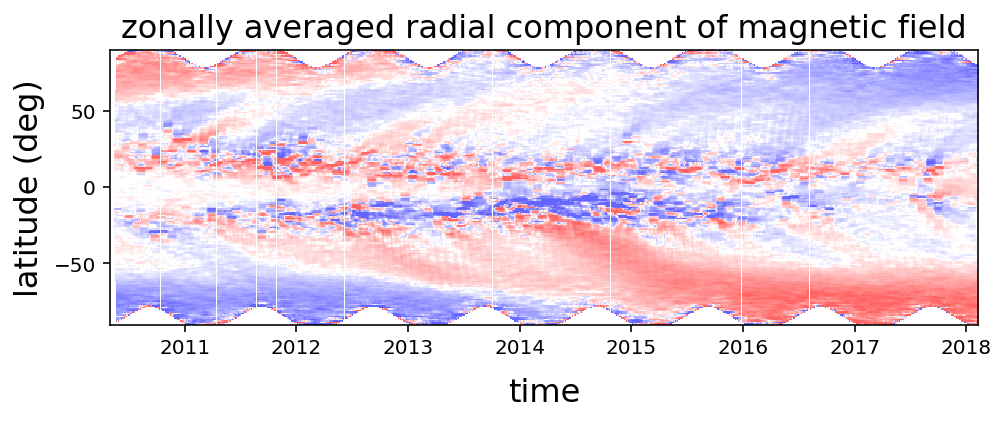

In [10]:
fig = plot_butterfly(hmidata, hmidates, hmisteps)

We can save this visualization as a html file:

In [11]:
mpld3.save_html(fig,'butterfly.html')

Now we will plot item [2], the SoHO/MDI and SDO/HMI data together. The MDI mean polar field data is computed using a C [module](http://jsoc.stanford.edu/cvs/JSOC/proj/mag/polarfield/apps/meanpf.c) that takes the JSOC DRMS series [mdi.fd_M_96m_lev182](http://jsoc.stanford.edu/ajax/lookdata.html?ds=mdi.fd_M_96m_lev182) as an input. <br> 

For this butterfly diagram, we'll generate a `png` image.

In [12]:
# disable d3 rendering
mpld3.disable_notebook()

# gather all the SoHO/MDI data at a sampling of once per day
query = "ds=mdi.meanpf_96m[1996.05.01_00_TAI-2010.05.01_00_TAI@1d]&op=rs_list&key=T_REC&seg=mf_br"
url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?"

# read the data
response = requests.get(url+query)
data = response.json()
t_rec = data['keywords'][0]['values']
filename = data['segments'][0]['values']

# print some statistics
n_elements = len(filename)
print("There are "+str(n_elements)+" files.")
print("first rec is "+t_rec[0]+" file="+filename[0])
print("last rec is "+t_rec[-1]+" file="+filename[-1])

There are 4689 files.
first rec is 1996.05.01_00:00:00_TAI file=/SUM81/D775535571/S00048/mf_br.fits
last rec is 2010.05.01_00:00:00_TAI file=/SUM75/D775552012/S00037/mf_br.fits


In [13]:
mdidata, mdidates, mdisteps = gather_the_polar_field_data(t_rec, filename, n_elements)

There are 1022 pixels greater than 200 G.
Now there are 0 pixels greater than 200 G.


In [14]:
mdidata, mdidates, mdisteps = process_the_polar_field_data(mdidata, mdidates, mdisteps)

j= 0   nan
j= 392   0.674498929304
j= 764   0.348760748653
j= 1314   0.824663394225
j= 1686   0.149758673804
j= 2055   -0.0799910614135
j= 2428   0.413481400205
j= 2823   0.0692021140336
j= 3216   0.485531474801
j= 3595   -0.229131397906
j= 3985   0.428663260876
j= 4369   1.08027578306
j= 4767   0.479979238438


We can plot the SoHO/MDI data on its own:

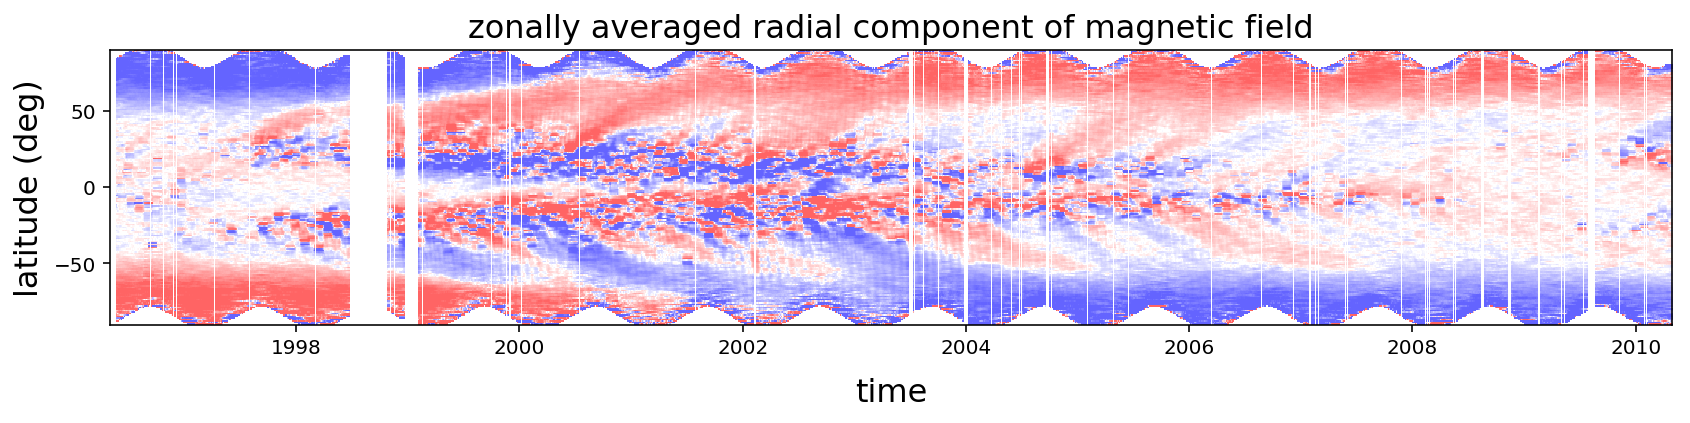

In [15]:
fig = plot_butterfly(mdidata, mdidates, mdisteps)

Now we can create a macro-butterfly diagram by combining the data from both the SDO/HMI and SoHO/MDI instruments. First we multiply the HMI data by a factor of 1.2, because the magnetic field strength as measured by HMI is about 1.2 times weaker than those measured by MDI ([Liu et al., 2012](http://adsabs.harvard.edu/abs/2012SoPh..279..295L])). The number 1.2 is not exact, as this factor is a function of latitude, but 1.2 is a good overall choice.

In [16]:
hmidata_stronger = 1.2*hmidata

Now we combine the HMI and MDI data into one array:

In [17]:
totaldata = np.ndarray([180,mdidata.shape[1]+hmidata_stronger.shape[1]])
totaldata[:,0:mdidata.shape[1]] = mdidata
totaldata[:,mdidata.shape[1]:mdidata.shape[1]+hmidata_stronger.shape[1]] = hmidata_stronger
print("The total data array has the following dimensions:", totaldata.shape, ".")

The total data array has the following dimensions: (180, 7957) .


We also determine the number of time steps, represented as columns, in the butterfly diagram:

In [18]:
totalsteps = hmisteps + mdisteps
print("There are", totalsteps, "total time steps.")

There are 7957 total time steps.


Finally, we determine the range of dates plotted in the butterfly diagram:

In [19]:
totaldates = np.arange(mdidates[0],hmidates[-1])

And then we can plot the macro-butterfly diagram, which spans nearly two solar cyles from 1996 to the present day:

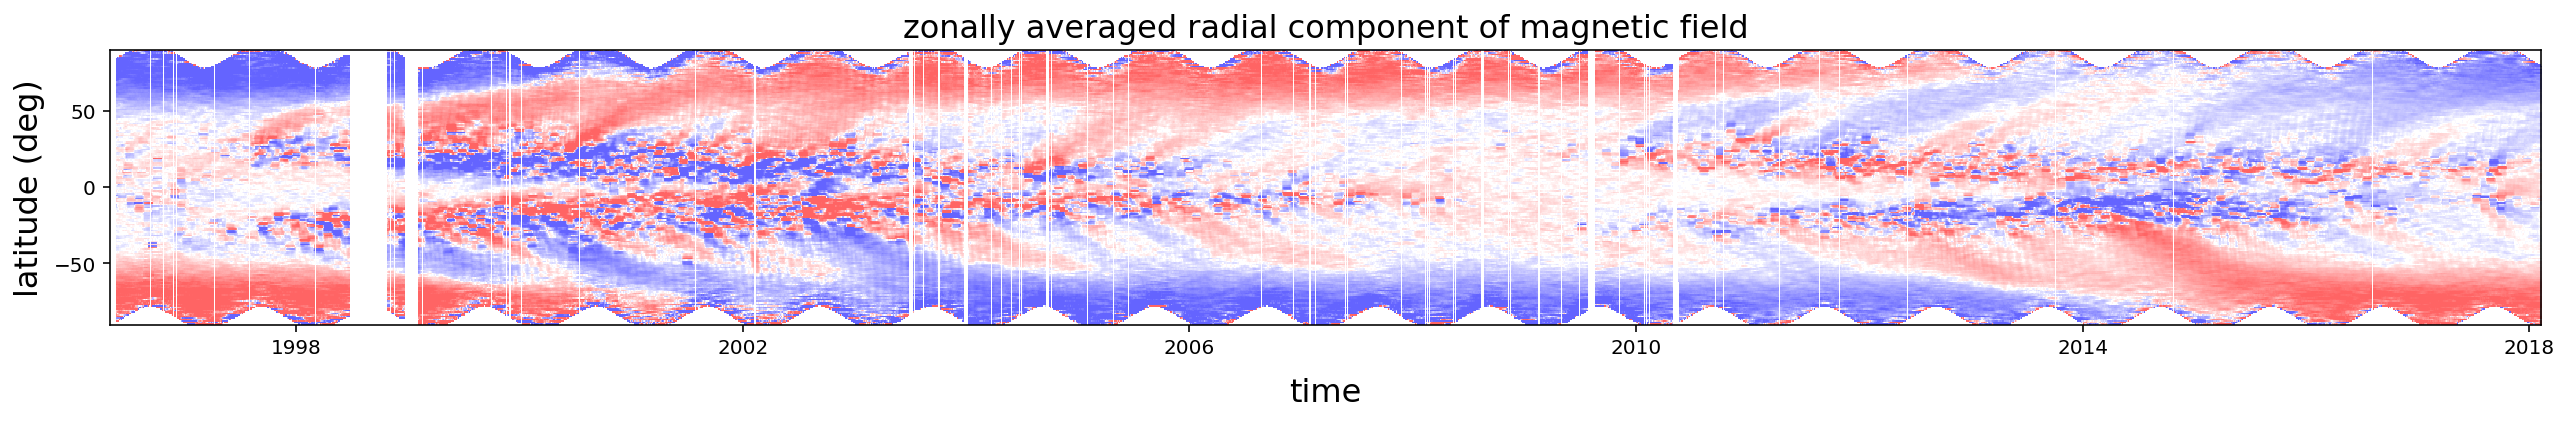

In [20]:
fig = plot_butterfly(totaldata, totaldates, totalsteps)

Awesome! We can save this image as a high-resolution png file:

In [21]:
fig.savefig('butterfly.png',dpi=300)

In [22]:
mpld3.save_html(fig,'supersynoptic.html')